In [1]:
%matplotlib inline
# from memory_profiler import memory_usage
import os
import pandas as pd
from glob import glob
import numpy as np

In [2]:
from keras import layers
from keras import models
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
import keras.backend as K
import librosa
import librosa.display
import pylab
import matplotlib.pyplot as plt
from matplotlib import figure
import gc
# from path import Path

Using TensorFlow backend.


In [3]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

import os
from glob import glob

#### First step is to create a picture from the audio file

In [13]:
#list the files
filelist = os.listdir('male') 
#read them into pandas
df_male = pd.DataFrame(filelist)

In [14]:
# Adding the 1 label to the dataframe representing male
df_male['label']='1'

In [15]:
# Renaming the column name to file
df_male = df_male.rename(columns={0:'file'})

In [16]:
df_male.head()

,file,label
0,2893-139322-0000.flac,1
1,1034-121119-0071.flac,1
2,78-369-0018.flac,1
3,322-124147-0038.flac,1
4,831-130739-0049.flac,1


In [17]:
# Checking for a file that gets automatically generated and we need to drop 
df_male[df_male['file']=='.DS_Store']

,file,label


In [18]:
filelist = os.listdir('female') 
#read them into pandas
df_female = pd.DataFrame(filelist)

In [19]:
df_female['label']='0'

In [20]:
df_female = df_female.rename(columns={0:'file'})

In [21]:
df_female.head()

,file,label
0,441-128982-0010.flac,0
1,1502-122619-0039.flac,0
2,302-123504-0010.flac,0
3,1553-140048-0029.flac,0
4,32-21625-0013.flac,0


In [22]:
# Checking for a file that gets automatically generated and we need to drop 
df_female[df_female['file']=='.DS_Store']

,file,label
981,.DS_Store,0


In [23]:
# Dropping the system file
df_female.drop(981, inplace=True)

In [24]:
# Resetting the index since we dropped a row
df_female = df_female.reset_index(drop=True)

In [25]:
df = pd.concat([df_female, df_male], ignore_index=True)

In [26]:
df.head()

,file,label
0,441-128982-0010.flac,0
1,1502-122619-0039.flac,0
2,302-123504-0010.flac,0
3,1553-140048-0029.flac,0
4,32-21625-0013.flac,0


In [27]:
# Randomizing our files to be able to split into train, validation and test
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [28]:
df_train = df[:9188]

In [29]:
df_train['label'].value_counts(normalize=True)

0    0.506748
1    0.493252
Name: label, dtype: float64

In [30]:
df_validation = df[9188:11813]

In [31]:
df_validation['label'].value_counts(normalize=True)

1    0.519619
0    0.480381
Name: label, dtype: float64

In [32]:
df_test = df[11813:13125]

In [33]:
df_test['label'].value_counts(normalize=True)

1    0.502287
0    0.497713
Name: label, dtype: float64

#### Visualizing the melspectrogram (We will explain soon how to create this images)

In [6]:
# Randomly choosing one of the audio files
filename = 'female/441-128982-0010.flac'

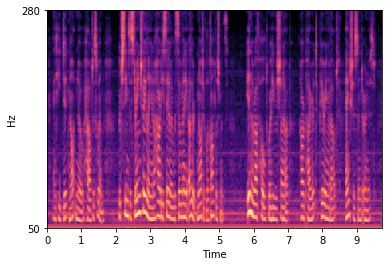

In [7]:
# Checking how the image looks like with the frequency restriction
X, sample_rate = librosa.load(filename, sr=None, res_type='kaiser_fast')
S = librosa.feature.melspectrogram(y=X, sr=sample_rate)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', fmin=50, fmax=280)
plt.show()

Using a function to generate and save the melspectrogram for each audio file

In [359]:
# Although this function was modified and many parameteres were explored with, most of it
# came from Source 18 (sources in the READ.ME)

def images(files):
    
    # We define the audiofile from the rows of the dataframe when we iterate through
    # every row of our dataframe for train, val and test
    audiofile = os.path.join(os.path.abspath('new_test_male_female')+'/'+str(files.file))
    
    # Loading the image with no sample rate to use the original sample rate and
    # kaiser_fast to make the speed faster according to a blog post about it (on references)
    X, sample_rate = librosa.load(audiofile, sr=None, res_type='kaiser_fast')
   
    # Setting the size of the image
    fig = plt.figure(figsize=[1,1])
    
    # This is to get rid of the axes and only get the picture 
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_frame_on(False)
    
    # This is the melspectrogram from the decibels with a linear relationship
    # Setting min and max frequency to account for human voice frequency
    S = librosa.feature.melspectrogram(y=X, sr=sample_rate)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', fmin=50, fmax=280)
    
    # Here we choose the path and the name to save the file, we will change the path when
    # using the function for train, val and test to make the function easy to use and output
    # the images in different folders to use later with a generator
    name = files.file
    file  = 'voice_images_test_new/' + str(name) + '.jpg'
    
    # Here we finally save the image file choosing the resolution 
    plt.savefig(file, dpi=500, bbox_inches='tight',pad_inches=0)
    
    # Here we close the image because otherwise we get a warning saying that the image stays
    # open and consumes memory
    plt.close()

Now we load the dataframe and slice the data into train, validation and testing data like before. Again, 3435 for training, 1000 for validation and 1000 for testing.

In [79]:
train = df[:10_000]
val = df[10_000:12_000]
test = df[12_000:13_000]

We use the function to create all the images from train, val and test

In [58]:
train.apply(images, axis=1);

In [56]:
test.apply(images, axis=1);

In [53]:
val.apply(images, axis=1);

In [59]:
plt.close('all')

In [1265]:
# Code to let us know when the code finishes running
os.system('say -v Juan ya acabé');

We will use the datagen.flow_from_dataframe from the keras documentation to use with the CNN
https://keras.io/preprocessing/image/

![keras](img/keras.jpg)

In [107]:
# Function to change the file names to the image names to use them later 
def make_jpg(files):
    return str(files.split('.')[0])+'.flac.jpg'

In [108]:
train['file'] = train['file'].apply(make_jpg)

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [109]:
val['file'] = val["file"].apply(make_jpg)

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
test['file'] = test["file"].apply(make_jpg)

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [91]:
# Rescaling the images as usual to feed into the CNN
datagen=ImageDataGenerator(rescale=1./255.)

In [113]:
train_generator=datagen.flow_from_dataframe(
    dataframe=train,
    directory="voice_images_train",
    x_col="file",
    y_col="label",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(64,64))

Found 10000 validated image filenames belonging to 2 classes.


In [114]:
val_generator=datagen.flow_from_dataframe(
    dataframe=val,
    directory="voice_images_val",
    x_col="file",
    y_col="label",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(64,64))

Found 2000 validated image filenames belonging to 2 classes.


In [287]:
test_generator=datagen.flow_from_dataframe(
    dataframe=test,
    directory="voice_images_test",
    x_col="file",
    y_col="label",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(64,64))

Found 1000 validated image filenames belonging to 2 classes.


In [117]:
plt.close('all')

In [1509]:
# import os
os.system('say -v Juan ya acabé');

### Now we finally can build the CNN model and fit it

In [8]:
# Building our model 
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [128]:
# Compiling using adam and categorical crossentropy
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 128)        

In [129]:
# Fitting our CNN with 250 epochs and setting the results to history for visuals
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=313,
                    validation_data=val_generator,
                    validation_steps=63,
                    epochs=100)

Epoch 1/100
313/313 [==============================] - 66s 209ms/step - loss: 0.6929 - accuracy: 0.5240 - val_loss: 0.7106 - val_accuracy: 0.5230
Epoch 2/100
313/313 [==============================] - 65s 207ms/step - loss: 0.6800 - accuracy: 0.5805 - val_loss: 0.7189 - val_accuracy: 0.5295
Epoch 3/100
313/313 [==============================] - 64s 206ms/step - loss: 0.6293 - accuracy: 0.6420 - val_loss: 0.6130 - val_accuracy: 0.7305
Epoch 4/100
313/313 [==============================] - 65s 209ms/step - loss: 0.3651 - accuracy: 0.8429 - val_loss: 0.2565 - val_accuracy: 0.9365
Epoch 5/100
313/313 [==============================] - 68s 218ms/step - loss: 0.1973 - accuracy: 0.9339 - val_loss: 0.2372 - val_accuracy: 0.9380
Epoch 6/100
313/313 [==============================] - 72s 232ms/step - loss: 0.1610 - accuracy: 0.9442 - val_loss: 0.0740 - val_accuracy: 0.9505
Epoch 7/100
313/313 [==============================] - 55s 175ms/step - loss: 0.1566 - accuracy: 0.9465 - val_loss: 0.0826 -

Epoch 57/100
313/313 [==============================] - 64s 204ms/step - loss: 0.0720 - accuracy: 0.9782 - val_loss: 0.0178 - val_accuracy: 0.9835
Epoch 58/100
313/313 [==============================] - 60s 193ms/step - loss: 0.0656 - accuracy: 0.9788 - val_loss: 0.0381 - val_accuracy: 0.9815
Epoch 59/100
313/313 [==============================] - 62s 199ms/step - loss: 0.0635 - accuracy: 0.9804 - val_loss: 0.0330 - val_accuracy: 0.9835
Epoch 60/100
313/313 [==============================] - 61s 195ms/step - loss: 0.0667 - accuracy: 0.9802 - val_loss: 0.0780 - val_accuracy: 0.9795
Epoch 61/100
313/313 [==============================] - 65s 209ms/step - loss: 0.0614 - accuracy: 0.9781 - val_loss: 0.0792 - val_accuracy: 0.9810
Epoch 62/100
313/313 [==============================] - 64s 203ms/step - loss: 0.0606 - accuracy: 0.9803 - val_loss: 0.0462 - val_accuracy: 0.9800
Epoch 63/100
313/313 [==============================] - 64s 206ms/step - loss: 0.0626 - accuracy: 0.9779 - val_loss: 0

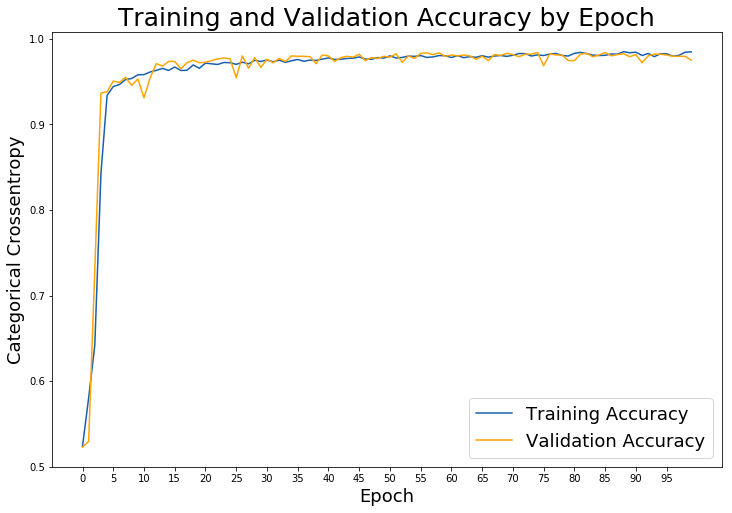

In [130]:
# Check out our train accuracy and validation accuracy over epochs.
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18)
plt.show();

In [297]:
test

,file,label,predictions
12000,2196-170151-0030.flac.jpg,0,0
12001,3436-172162-0003.flac.jpg,1,1
12002,1098-133695-0078.flac.jpg,0,0
12003,446-123502-0011.flac.jpg,1,1
12004,441-128982-0025.flac.jpg,0,0
...,...,...,...
12995,196-122150-0023.flac.jpg,1,1
12996,1970-10594-0021.flac.jpg,0,0
12997,669-129061-0062.flac.jpg,0,0
12998,1624-142933-0027.flac.jpg,1,1


In [298]:
preds = model.predict_generator(test_generator)

In [299]:
preds

array([[9.6926647e-01, 3.0733489e-02],
       [7.3766365e-04, 9.9926227e-01],
       [9.8911065e-01, 1.0889274e-02],
       ...,
       [9.7418076e-01, 2.5819227e-02],
       [4.7055119e-06, 9.9999535e-01],
       [3.6702168e-08, 1.0000000e+00]], dtype=float32)

In [300]:
p = []
for i in range(0, len(preds)):
    p.append(np.where(preds[i] == max(preds[i])))

In [301]:
predictions = []
for i in range(0, len(preds)):
    predictions.append(p[i][0][0])

In [302]:
test['predictions'] = predictions

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [303]:
test['predictions'] = test['predictions'].astype(str)

/Users/jurgenarias/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [305]:
round(len(test[test['label'] == test['predictions']])/len(test),4)

0.977

### We got 97.7% accuracy on our test data

But the test data is made of speakers that our model already knows because it has heard them before in the training data so this accuracy does not really reflect unseen data

In [345]:
filelist = os.listdir('test_female') 
#read them into pandas
df_female = pd.DataFrame(filelist)

In [346]:
df_female['label']='0'

In [347]:
df_female = df_female.rename(columns={0:'file'})

In [348]:
df_female[df_female['file']=='.DS_Store']

,file,label
7,.DS_Store,0


In [349]:
df_female.drop(7, inplace=True)

In [350]:
df_female = df_female.reset_index(drop=True)

In [351]:
filelist = os.listdir('test_male') 
#read them into pandas
df_male = pd.DataFrame(filelist)

In [352]:
df_male['label']='1'

In [353]:
df_male = df_male.rename(columns={0:'file'})

In [354]:
df_male[df_male['file']=='.DS_Store']

,file,label
6,.DS_Store,1


In [355]:
df_male.drop(6, inplace=True)

In [356]:
df_male = df_male.reset_index(drop=True)

In [357]:
df = pd.concat([df_female, df_male], ignore_index=True)

In [358]:
df

,file,label
0,2910-131096-0007.flac,0
1,5778-12761-0000.flac,0
2,4680-16026-0000.flac,0
3,6272-70168-0000.flac,0
4,5867-48852-0000.flac,0
...,...,...
95,7447-91186-0000.flac,1
96,4830-25898-0000.flac,1
97,4788-91208-0000.flac,1
98,6367-65536-0000.flac,1


In [360]:
df.apply(images, axis=1);

In [361]:
# Function to change the file names to the image names to use them later 
def make_jpg(files):
    return str(files)+'.jpg'

In [362]:
df['file'] = df['file'].apply(make_jpg)

In [363]:
df

,file,label
0,2910-131096-0007.flac.jpg,0
1,5778-12761-0000.flac.jpg,0
2,4680-16026-0000.flac.jpg,0
3,6272-70168-0000.flac.jpg,0
4,5867-48852-0000.flac.jpg,0
...,...,...
95,7447-91186-0000.flac.jpg,1
96,4830-25898-0000.flac.jpg,1
97,4788-91208-0000.flac.jpg,1
98,6367-65536-0000.flac.jpg,1


In [364]:
test_generator=datagen.flow_from_dataframe(
    dataframe=df,
    directory="voice_images_test_new",
    x_col="file",
    y_col="label",
    batch_size=32,
    shuffle=False,
    class_mode="categorical",
    target_size=(64,64))

Found 100 validated image filenames belonging to 2 classes.


In [365]:
preds = model.predict_generator(test_generator)

In [366]:
p = []
for i in range(0, len(preds)):
    p.append(np.where(preds[i] == max(preds[i])))

In [367]:
predictions = []
for i in range(0, len(preds)):
    predictions.append(p[i][0][0])

In [368]:
df['predictions'] = predictions

In [369]:
df['predictions'] = df['predictions'].astype(str)

In [370]:
df[df['label'] != df['predictions']]

,file,label,predictions
26,6531-61334-0037.flac.jpg,0,1
52,3607-29116-0008.flac.jpg,1,0
68,6019-3185-0000.flac.jpg,1,0
73,3830-12529-0001.flac.jpg,1,0
85,4406-16882-0000.flac.jpg,1,0


In [372]:
round(len(df[df['label'] == df['predictions']])/len(df),4)

0.95

#### We got 95% accuracy on our test never before seen data

In [1588]:
# Saving the dataframe to use with our Dense NN to use as a voting classifier 
predic_cnn = pd.DataFrame(preds)

predic_cnn.to_csv('predict_cnn.csv', index=False)

In [1526]:
os.system('say -v Juan ya acabé');